In [18]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KernelDensity
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
df = pd.read_csv('../data/clean_data/merged_df.csv')

In [23]:


# Features and target variable
X = df[["Avg_temp_june_value", "Min_temp_june_value", "Precipitation_june_value", "Avg_cooling_degree_days_june"]]
y = df["total_lyme_disease_counts"]

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 1. Random Forest
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_scaled, y_train)
rf_preds = rf_model.predict(X_test_scaled)

# 2. Gradient Boosted Trees
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train_scaled, y_train)
gb_preds = gb_model.predict(X_test_scaled)

# 3. K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train_scaled, y_train)
knn_preds = knn_model.predict(X_test_scaled)

# 4. Decision Trees
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train_scaled, y_train)
dt_preds = dt_model.predict(X_test_scaled)

# 5. Bayesian KDE for regression-like task
kde = KernelDensity(kernel='gaussian', bandwidth=1.0).fit(X_train_scaled)
kde_density = kde.score_samples(X_test_scaled)  # Log-density estimates
kde_preds = np.exp(kde_density)  # Convert log-density to probabilities for comparison

# 6. PyTorch Linear Regression
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Model initialization
input_dim = X_train_tensor.shape[1]
lr_model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(lr_model.parameters(), lr=0.01)

# Training
epochs = 100
for epoch in range(epochs):
    lr_model.train()
    optimizer.zero_grad()
    outputs = lr_model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

# Predictions
lr_model.eval()
with torch.no_grad():
    lr_preds = lr_model(X_test_tensor).numpy().flatten()

# # Evaluation
# def evaluate_model(y_true, y_preds, model_name):
#     rmse = mean_squared_error(y_true, y_preds, squared=False)
#     r2 = r2_score(y_true, y_preds)
#     print(f"{model_name} - RMSE: {rmse}, R2 Score: {r2}")

# evaluate_model(y_test, rf_preds, "Random Forest")
# evaluate_model(y_test, gb_preds, "Gradient Boosted Trees")
# evaluate_model(y_test, knn_preds, "K-Nearest Neighbors")
# evaluate_model(y_test, dt_preds, "Decision Trees")
# evaluate_model(y_test, kde_preds, "KDE (Regression)")
# evaluate_model(y_test_tensor.numpy().flatten(), lr_preds, "Linear Regression (PyTorch)")

# Evaluation function
def evaluate_model(y_true, y_preds):
    rmse = mean_squared_error(y_true, y_preds, squared=False)
    r2 = r2_score(y_true, y_preds)
    return rmse, r2

# Evaluate the models
rf_rmse, rf_r2 = evaluate_model(y_test, rf_preds)
gb_rmse, gb_r2 = evaluate_model(y_test, gb_preds) 
knn_rmse, knn_r2 = evaluate_model(y_test, knn_preds)
dt_rmse, dt_r2 = evaluate_model(y_test, dt_preds)
kde_rmse, kde_r2 = evaluate_model(y_test, kde_preds)
lr_rmse, lr_r2 = evaluate_model(y_test_tensor.numpy().flatten(), lr_preds)



/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/metrics/_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use 

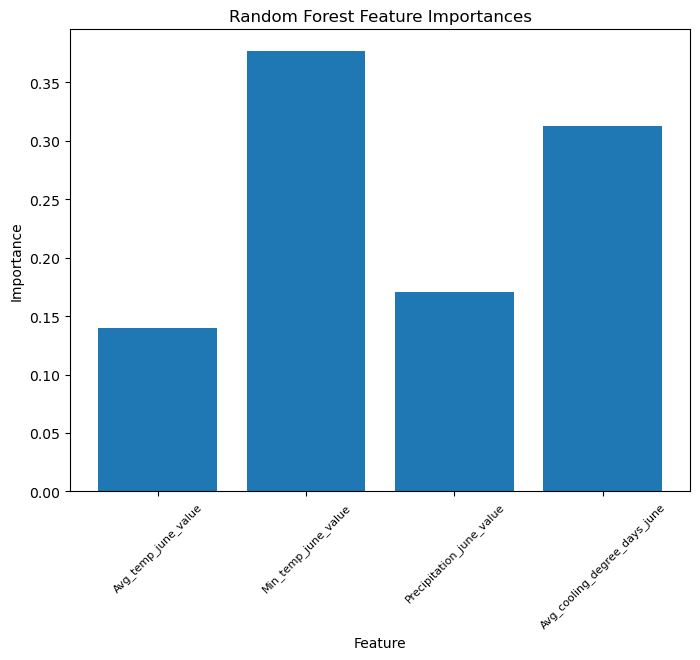

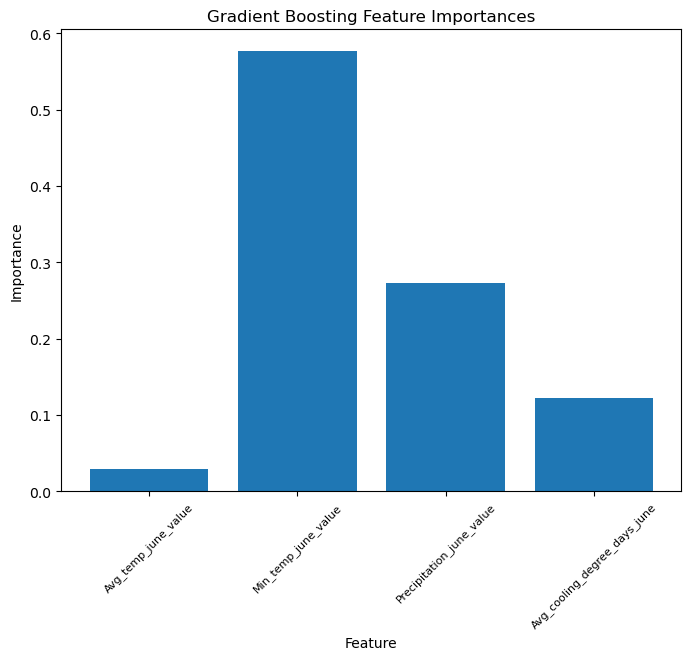

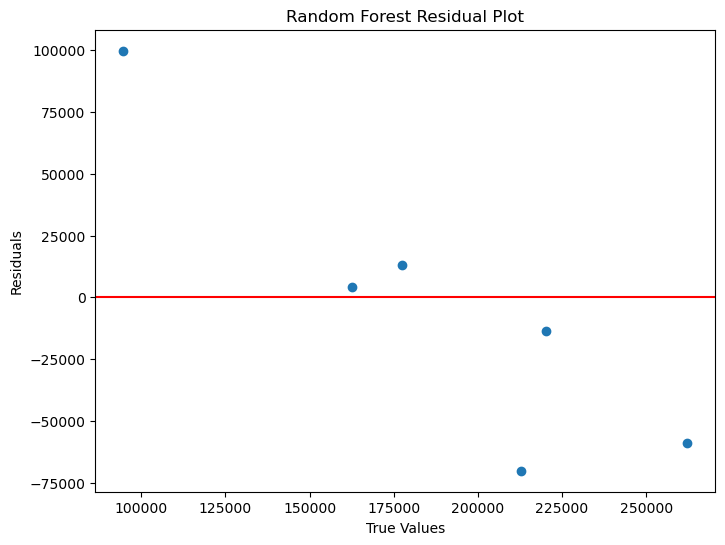

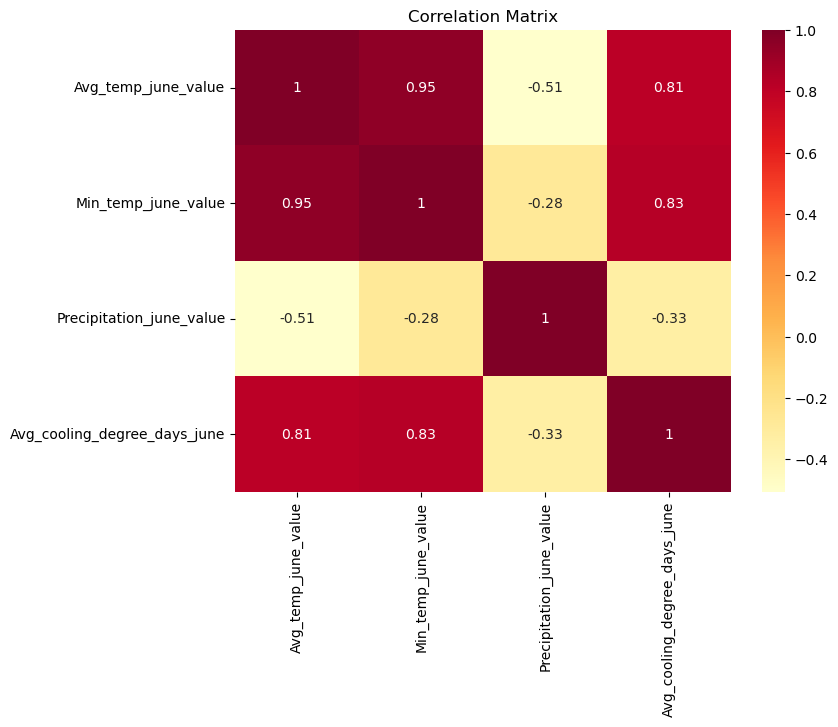

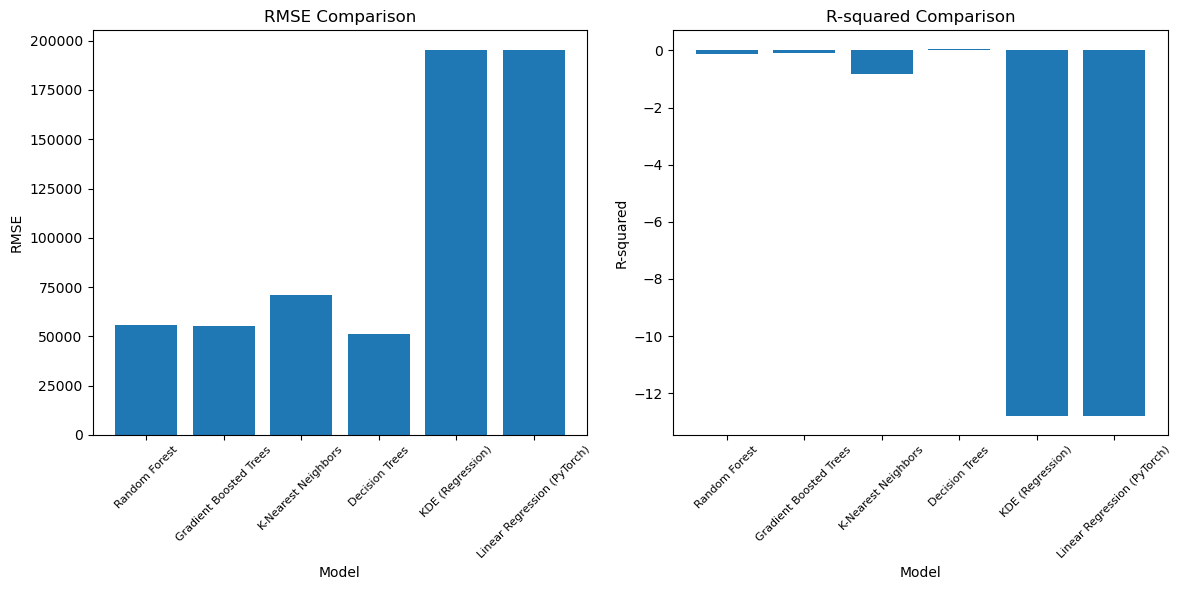

In [28]:
# VISUALIZATIONS
# Random Forest feature importance
plt.figure(figsize=(8, 6))
plt.bar(X.columns, rf_model.feature_importances_)
plt.title("Random Forest Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, fontsize=8)
plt.show()

# Gradient Boosting feature importance
plt.figure(figsize=(8, 6))
plt.bar(X.columns, gb_model.feature_importances_)
plt.title("Gradient Boosting Feature Importances")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.xticks(rotation=45, fontsize=8)
plt.show()

# Residual plot for Random Forest
plt.figure(figsize=(8, 6))
plt.scatter(y_test, rf_preds - y_test)
plt.axhline(y=0, color='r', linestyle='-')
plt.title("Random Forest Residual Plot")
plt.xlabel("True Values")
plt.ylabel("Residuals")
plt.show()


# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(X.corr(), annot=True, cmap="YlOrRd")
plt.title("Correlation Matrix")
plt.show()


# Model comparison plot
model_names = ["Random Forest", "Gradient Boosted Trees", "K-Nearest Neighbors", "Decision Trees", "KDE (Regression)", "Linear Regression (PyTorch)"]
rmse_values = [rf_rmse, gb_rmse, knn_rmse, dt_rmse, kde_rmse, lr_rmse]
r2_values = [rf_r2, gb_r2, knn_r2, dt_r2, kde_r2, lr_r2]

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.bar(model_names, rmse_values)
plt.title("RMSE Comparison")
plt.xlabel("Model")
plt.ylabel("RMSE")
plt.xticks(rotation=45, fontsize=8)
plt.subplot(1, 2, 2)
plt.bar(model_names, r2_values)
plt.title("R-squared Comparison")
plt.xlabel("Model")
plt.ylabel("R-squared")
plt.xticks(rotation=45, fontsize=8)
plt.tight_layout()
plt.show()

None of these models are very strong at all, but the best performing one appears to be the Decision Tree. Thus, Decision Tree will be used to perform predictions for the number of Lyme disease cases in the year 2042, under RCP 8.5's predicted average temperature, minimum temperature, and average precipitation in the month of June in that year. 

In [22]:
# Example new data for 2042
new_data = pd.DataFrame({
    "Avg_temp_june_value": [75.0],  # Replace with projected value for 2042
    "Min_temp_june_value": [60.0],  # Replace with projected value
    "Precipitation_june_value": [3.5],  # Replace with projected value
    "Avg_cooling_degree_days_june": [10.0]  # Replace with projected value
})

# Scale the new data using the same scaler used for training
new_data_scaled = scaler.transform(new_data)

# Predict Lyme disease counts for 2042
predicted_counts_2042 = dt_model.predict(new_data_scaled)
print("Predicted total Lyme disease counts in 2042:", predicted_counts_2042)


Predicted total Lyme disease counts in 2042: [284622.13910337]


## STATE supervised learning

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# First, let's calculate the percent changes for tree coverage and species richness
def calculate_percent_changes(df):
    # Get data for 2008 and 2022
    df_2008 = df[df['Year'] == 2008].copy()
    df_2022 = df[df['Year'] == 2022].copy()
    
    # Calculate percent changes
    changes = pd.DataFrame()
    changes['State'] = df_2008['State'].unique()
    changes['region'] = df_2008[df_2008['State'].isin(changes['State'])]['region']
    
    # Calculate tree cover loss percent change with handling for zeros and NaN
    df_2008_tree = df_2008.set_index('State')['Tree_Cover_Loss'].replace(0, 0.01)  # Replace zeros with small value
    df_2022_tree = df_2022.set_index('State')['Tree_Cover_Loss'].replace(0, 0.01)
    
    changes['tree_cover_change_pct'] = ((df_2022_tree - df_2008_tree) / df_2008_tree * 100)
    
    # Calculate species richness percent change with handling for zeros and NaN
    df_2008_species = df_2008.set_index('State')['species_richness'].replace(0, 0.01)
    df_2022_species = df_2022.set_index('State')['species_richness'].replace(0, 0.01)
    
    changes['species_richness_change_pct'] = ((df_2022_species - df_2008_species) / df_2008_species * 100)
    
    return changes

# Prepare data for modeling
def prepare_modeling_data(df, changes_df):
    # Create future prediction dataset
    future_data = pd.DataFrame()
    
    # Add your RCP 8.5 climate projections for 2042
    future_data['Precipitation_avg'] = df[df['Year'] == 2022]['Precipitation_avg']
    future_data['Min_temp_avg'] = df[df['Year'] == 2022]['Min_temp_avg'] + 2  # Example increment
    future_data['Avg_temp'] = df[df['Year'] == 2022]['Avg_temp'] + 2  # Example increment
    
    # Add constant features
    future_data['Total_Land_Area'] = df[df['Year'] == 2022]['Total_Land_Area']
    
    # Add the calculated percent changes
    future_data = future_data.join(changes_df[['tree_cover_change_pct', 'species_richness_change_pct']])
    
    return future_data

# Train different models and evaluate them
def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'Random Forest': RandomForestRegressor(n_estimators=100),
        'SVR': SVR(kernel='rbf')
    }
    
    results = {}
    for name, model in models.items():
        # Train model
        model.fit(X_train, y_train)
        
        # Make predictions
        y_pred = model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        results[name] = {
            'MSE': mse,
            'R2': r2,
            'Model': model
        }
    
    return results

# Main execution
# Load your data
df = pd.read_csv('../data/clean_data/state_data.csv')

# Print initial info about missing values
print("Missing values before imputation:")
print(df.isnull().sum())

# Calculate percent changes
changes_df = calculate_percent_changes(df)

# Prepare features
features = ['Precipitation_avg', 'Min_temp_avg', 'Avg_temp', 'Total_Land_Area', 
           'Tree_Cover_Loss', 'species_richness']
X = df[features].values
y = df['Lyme_cases'].values

# Handle missing values using imputation
imputer = SimpleImputer(strategy='mean')
X = imputer.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train and evaluate models
results = train_and_evaluate_models(X_train_scaled, X_test_scaled, y_train, y_test)

# Print results
print("\nModel Performance Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"MSE: {metrics['MSE']:.2f}")
    print(f"R2 Score: {metrics['R2']:.2f}")

# Prepare future prediction data
future_data = prepare_modeling_data(df, changes_df)

# Impute any missing values in future data
future_data = pd.DataFrame(imputer.transform(future_data), columns=future_data.columns)

# Make predictions for 2042
print("\nPredictions for 2042:")
for name, metrics in results.items():
    future_pred = metrics['Model'].predict(scaler.transform(future_data))
    print(f"\n{name} prediction:")
    print(f"Predicted Lyme cases: {future_pred.mean():.0f}")

Missing values before imputation:
Year                  0
Precipitation_avg     0
region                0
Min_temp_avg          0
Avg_temp              0
State                 0
Lyme_cases            0
Total_Land_Area       0
Tree_Cover_Loss       0
species_richness     45
dtype: int64

Model Performance Comparison:

Linear Regression:
MSE: 1452510.92
R2 Score: 0.30

Ridge Regression:
MSE: 1424841.94
R2 Score: 0.32

Lasso Regression:
MSE: 1442448.05
R2 Score: 0.31

Random Forest:
MSE: 794366.63
R2 Score: 0.62

SVR:
MSE: 2559671.87
R2 Score: -0.23

Predictions for 2042:

Linear Regression prediction:
Predicted Lyme cases: 510

Ridge Regression prediction:
Predicted Lyme cases: 464

Lasso Regression prediction:
Predicted Lyme cases: 498

Random Forest prediction:
Predicted Lyme cases: 1213

SVR prediction:
Predicted Lyme cases: 75


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but SimpleImputer was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings